In [1]:

# !pip install geopandas rasterio fiona shapely earthengine-api rnassqs pandas numpy folium
# Install required packages (run once)
!pip install geopandas rasterio fiona shapely earthengine-api pandas numpy folium geemap


  Using cached googleapis_common_protos-1.70.0-py3-none-any.whl.metadata (9.3 kB)
  Using cached proto_plus-1.26.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached rsa-4.9.1-py3-none-any.whl.metadata (5.6 kB)
  Using cached google_cloud_core-2.4.3-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached google_resumable_media-2.7.2-py2.py3-none-any.whl.metadata (2.2 kB)
  Using cached google_crc32c-1.7.1-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---- ----------------------------------- 2.9/25.4 MB 14.4 MB/s eta 0:00:02
   --------- ------------------------------ 5.8/25.4 MB 14.4 MB/s eta 0:00:02
   ------------- -------------------------- 8.7/25.4 MB 14.4 MB/s eta 0:00:02
   ------------------ --------------------- 11.5/25.4 MB 14.4 MB/s eta 0:00:01
   ---------------------- ----------------- 14.4/25.4 MB 14.4 MB/s eta 0:00:01
   --------------------------- ------------ 17.3/25.4 MB 14.4 MB/s eta 0:00:01
   ------

In [2]:
import urllib.request
import json
import pandas as pd

base_url = 'https://quickstats.nass.usda.gov/api/api_GET/'

# This is my own API key!
params = {
    'key': '606153B9-DDAD-30FB-88EE-5BCC60DEE678' ,
    'commodity_desc': 'CORN',
    'statisticcat_desc': 'PRODUCTION',
    'unit_desc': 'BU',
    'agg_level_desc': 'COUNTY',
    'state_name': 'MINNESOTA',
    'year__GE': '2000',
    'year__LE': '2024',
    'format': 'JSON'
}


query_string = '&'.join([f"{k}={v}" for k, v in params.items()])
full_url = base_url + '?' + query_string
with urllib.request.urlopen(full_url) as response:
    data = json.loads(response.read().decode())

corn_data = data['data']
corn_df = pd.DataFrame(corn_data)

corn_df = corn_df[['year', 'county_code', 'county_name', 'Value']]

# FIPS: Minnesota state code is 27, county_code is 3 digits
corn_df['fips'] = '27' + corn_df['county_code'].astype(str).str.zfill(3)

corn_df['Value'] = pd.to_numeric(corn_df['Value'].str.replace(',', '').replace('(D)', 'NaN'), errors='coerce')
corn_df = corn_df.rename(columns={'Value': 'corn_production_bu'})
corn_pivot = corn_df.pivot_table(index=['fips', 'county_name'], columns='year', values='corn_production_bu', aggfunc='first')

# corn_pivot.to_csv('mn_county_corn_production_2000_2022.csv')
corn_df.head(5)


,year,county_code,county_name,corn_production_bu,fips
0,2022,005,BECKER,12090339.0,27005
1,2017,005,BECKER,9713439.0,27005
2,2012,005,BECKER,10498515.0,27005
3,2007,005,BECKER,4514135.0,27005
4,2002,005,BECKER,1629672.0,27005


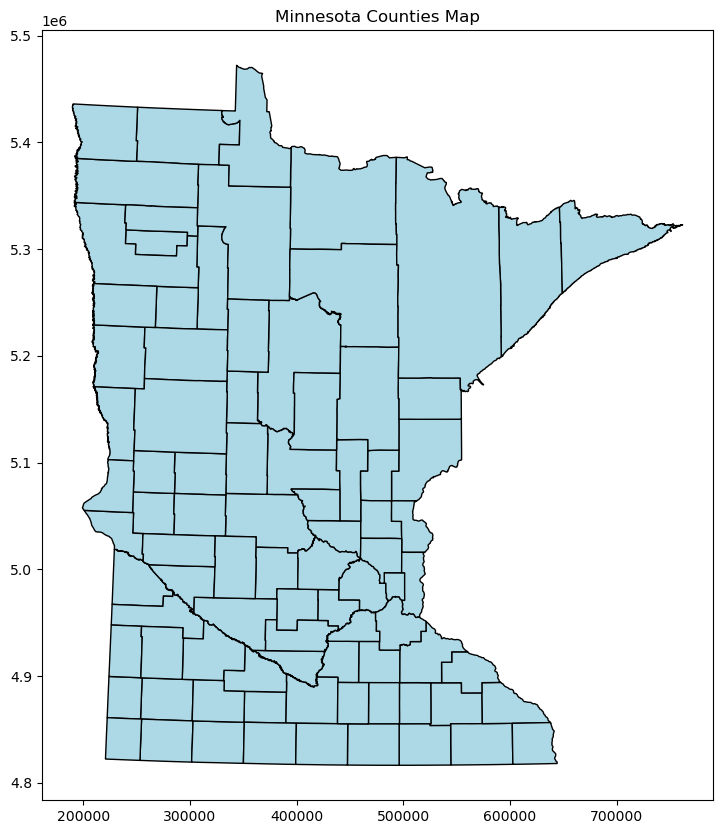

In [9]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import folium 
import matplotlib.pyplot as plt

# URL to Minnesota counties shapefile for geo location

mn_counties = gpd.read_file('Minnesota/mn_shp_bdry_counties.zip')
mn_counties.head(5)

fig, ax = plt.subplots(figsize=(10, 10))
mn_counties.plot(ax=ax, edgecolor='black', color='lightblue')
ax.set_title('Minnesota Counties Map')
plt.show()





In [1]:
# import counties
import ee

ee.Authenticate()
ee.Initialize()

ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))

ee_counties

In [5]:
import ee
import pandas as pd
import numpy as np
import geemap
import itertools
from tqdm import tqdm

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define years and months
years = list(range(2000, 2023))
months = list(range(2, 9))  # Feb to Aug

# Modified function to extract averages for all bands using TIGER counties for Minnesota
def get_county_averages_multi_band(collection, start_date, end_date):
    image = collection.filterDate(start_date, end_date).mean()
    
    # Get list of all band names
    band_names = image.bandNames().getInfo()
     
    # Load Minnesota counties from TIGER dataset
    ee_counties = ee.FeatureCollection("TIGER/2018/Counties").filter(ee.Filter.eq('STATEFP', '27'))
    
    # Reduce regions
    stats = image.reduceRegions(collection=ee_counties, reducer=ee.Reducer.mean(), scale=1000)
    results = stats.getInfo()
    
    data = []
    for feature in results['features']:
        props = feature['properties']
        row = {
            'fips': props['GEOID'],
            'county_name': props['NAME']
        }
        for band in band_names:
            row[band] = props.get(band, np.nan)
        data.append(row)
    return pd.DataFrame(data)

# GLDAS Collection (all 36 bands)
gldas = ee.ImageCollection('NASA/GLDAS/V021/NOAH/G025/T3H')

# Initialize dataframe for GLDAS data (all bands)
gldas_data = pd.DataFrame()

# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)

# Loop over years and months to collect data with progress bar
for year, month in tqdm(itertools.product(years, months), total=total_iterations, desc="Downloading GLDAS Data"):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    # Get averages for all bands
    monthly_data = get_county_averages_multi_band(gldas, start_date, end_date)
    
    # Add year and month columns
    monthly_data['year'] = year
    monthly_data['month'] = month
    
    # Append to main dataframe
    gldas_data = pd.concat([gldas_data, monthly_data], ignore_index=True)



# Optional: Visualize first image (example for one band)
Map = geemap.Map()
vis_params = {'bands': ['SoilMoi0_10cm_inst'], 'min': 0, 'max': 0.3}
image = gldas.first()
Map.addLayer(image, vis_params, 'First Image')
Map

# Display or save the data
print(gldas_data.head())
gldas_data.to_csv('gldas_all_bands_data.csv', index=False)

AttributeError: module 'ee.data' has no attribute '_credentials'

In [7]:

ee.Authenticate()
ee.Initialize()

print(gldas_data.head())
gldas_data.to_csv('gldas_all_bands_data.csv', index=False)

    fips    county_name  Albedo_inst  AvgSurfT_inst  CanopInt_inst  \
0  27073  Lac qui Parle    45.628617     268.901502       0.170420   
1  27153           Todd    56.148677     265.590273       0.206198   
2  27001         Aitkin    50.244838     264.970104       0.175215   
3  27057        Hubbard    48.491914     264.914661       0.210605   
4  27063        Jackson    50.091128     269.441418       0.199066   

   ECanop_tavg  ESoil_tavg  Evap_tavg  LWdown_f_tavg  Lwnet_tavg  ...  \
0     0.094085    4.831143   0.000005     259.458295  -35.648687  ...   
1     0.078237    2.168450   0.000003     249.600736  -31.664551  ...   
2     0.102708    2.679327   0.000004     243.178305  -34.681887  ...   
3     0.095990    2.421774   0.000003     244.762518  -32.901821  ...   
4     0.278989    5.146278   0.000006     262.570152  -35.010630  ...   

   SoilTMP0_10cm_inst  SoilTMP100_200cm_inst  SoilTMP10_40cm_inst  \
0          268.826365             274.867397           268.464492   
1 

In [4]:
# Calculate total iterations for progress bar
total_iterations = len(years) * len(months)

# Loop over years and months to collect data with progress bar
for year, month in tqdm(itertools.product(years, months), total=total_iterations, desc="Downloading GLDAS Data"):
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    
    # Get averages for all bands
    monthly_data = get_county_averages_multi_band(gldas, start_date, end_date)
    
    # Add year and month columns
    monthly_data['year'] = year
    monthly_data['month'] = month
    
    # Append to main dataframe
    gldas_data = pd.concat([gldas_data, monthly_data], ignore_index=True)

# Optional: Save the data
# gldas_data.to_csv('gldas_all_bands_data.csv', index=False)

# Display the first image from GLDAS for verification, adding layers for all 36 bands
Map = geemap.Map(center=[46.4, -94.5], zoom=6)  # Center on Minnesota

# Define band-specific min/max from dataset documentation (estimated values)
band_vis_dict = {
    'Albedo_inst': {'min': 4.99, 'max': 82.25},
    'AvgSurfT_inst': {'min': 187.48, 'max': 1323.35},
    'CanopInt_inst': {'min': 0, 'max': 0.5},
    'ECanop_tavg': {'min': 0, 'max': 1273.66},
    'ESoil_tavg': {'min': 0, 'max': 2275.63},
    'Evap_tavg': {'min': 0, 'max': 0.002},
    'LWdown_f_tavg': {'min': 26.85, 'max': 600.9},
    'Lwnet_tavg': {'min': -13792.7, 'max': 196.97},
    'PotEvap_tavg': {'min': -227.75, 'max': 18977.9},
    'Psurf_f_inst': {'min': 44063.1, 'max': 108344},
    'Qair_f_inst': {'min': -0.02, 'max': 0.07},
    'Qg_tavg': {'min': -552.64, 'max': 1538.41},
    'Qh_tavg': {'min': -1005.15, 'max': 18190.6},
    'Qle_tavg': {'min': -227.75, 'max': 5072.25},
    'Qs_acc': {'min': 0, 'max': 170.93},
    'Qsb_acc': {'min': 0, 'max': 50.6},
    'Qsm_acc': {'min': 0, 'max': 42.87},
    'Rainf_f_tavg': {'min': 0, 'max': 0.01},
    'Rainf_tavg': {'min': 0, 'max': 0.01},
    'RootMoist_inst': {'min': 2, 'max': 949.6},
    'SWE_inst': {'min': 0, 'max': 120787},
    'SWdown_f_tavg': {'min': -56.93, 'max': 30462.8},
    'SnowDepth_inst': {'min': 0, 'max': 301.96},
    'Snowf_tavg': {'min': 0, 'max': 0.009},
    'SoilMoi0_10cm_inst': {'min': 1.99, 'max': 47.59},
    'SoilMoi10_40cm_inst': {'min': 5.99, 'max': 142.8},
    'SoilMoi40_100cm_inst': {'min': 11.99, 'max': 285.6},
    'SoilMoi100_200cm_inst': {'min': 20, 'max': 476},
    'SoilTMP0_10cm_inst': {'min': 221.98, 'max': 377.5},
    'SoilTMP10_40cm_inst': {'min': 227.43, 'max': 319.44},
    'SoilTMP40_100cm_inst': {'min': 232.97, 'max': 316.2},
    'SoilTMP100_200cm_inst': {'min': 238.52, 'max': 314.11},
    'Swnet_tavg': {'min': -48.96, 'max': 23741.3},
    'Tair_f_inst': {'min': 206.8, 'max': 327.66},
    'Tveg_tavg': {'min': 0, 'max': 3455.14},
    'Wind_f_inst': {'min': 0, 'max': 57.7}
}

# Get a sample image (first from a specific date)
sample_gldas = gldas_data
image = sample_gldas.first()

# Get band names
band_names = image.bandNames().getInfo()

# Add a layer for each band with band-specific vis params
palette = ['blue', 'cyan', 'green', 'yellow', 'red']  # Common palette for visualization
for band in band_names:
    if band in band_vis_dict:
        vis_params = {
            'bands': [band],
            'min': band_vis_dict[band]['min'],
            'max': band_vis_dict[band]['max'],
            'palette': palette
        }
        Map.addLayer(image, vis_params, band)

# Print image info
print("First GLDAS Image Info:")
pprint.pprint(image.getInfo())

# Display the interactive map
display(Map)

KeyboardInterrupt: 

In [3]:
gldas_data_backup = gldas_data

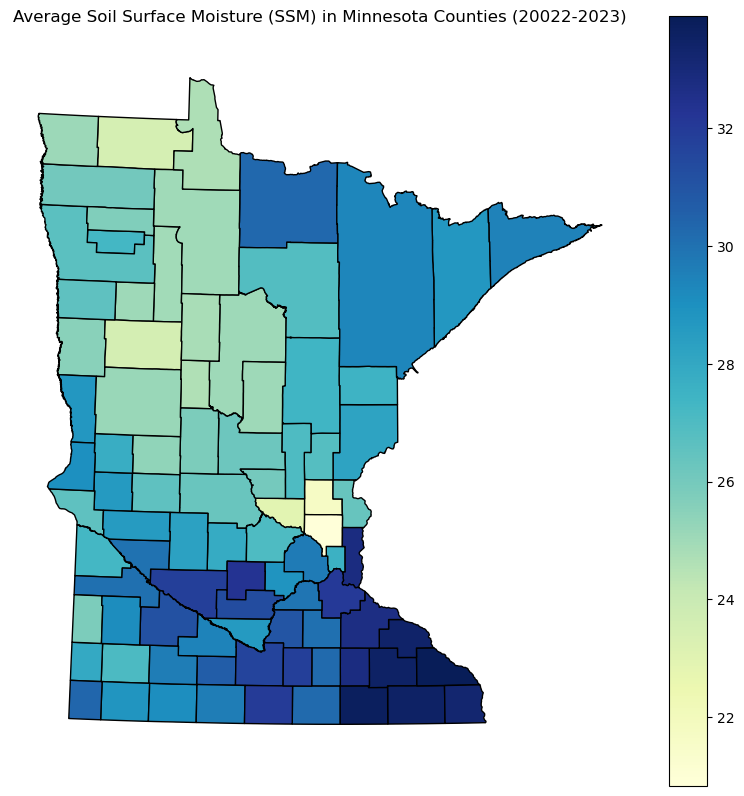

In [62]:
# mn_county_ndvi_2000_2022.csv
# mn_county_ssm_2000_2022.csv

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the SSM CSV
ssm_df = pd.read_csv('mn_county_ssm_2010_2022.csv')

# Rename the first two columns since they are unnamed in the CSV
ssm_df.columns = ['fips', 'county_name'] + list(ssm_df.columns[2:])

# Load the shapefile from zip (specify the shp inside)
mn_counties = gpd.read_file('Minnesota/County_Boundaries_in_Minnesota.shp')

# Prepare FIPS in mn_counties (MN state code 27 + 3-digit county code)
mn_counties['fips'] = '27' + mn_counties['COUNTY_FIP'].astype(str).str.zfill(3)
mn_counties['county_name'] = mn_counties['COUNTY_NAM']

# Reset index for ssm_df to make fips and county_name columns
ssm_df = ssm_df.reset_index()

# Compute average SSM per county
ssm_df['avg_ssm'] = ssm_df.mean(axis=1, numeric_only=True)

# Merge on 'fips'
merged = mn_counties.merge(ssm_df[['fips', 'avg_ssm']], on='fips', how='left')

# Plot choropleth map
fig, ax = plt.subplots(figsize=(10, 10))
merged.plot(column='avg_ssm', ax=ax, legend=True, cmap='YlGnBu', edgecolor='black', missing_kwds={'color': 'lightgrey'})
ax.set_title('Average Soil Surface Moisture (SSM) in Minnesota Counties (20022-2023)')
plt.axis('off')
plt.show()

In [63]:
ssm_df.head(5)

,index,fips,county_name,2010,2010.1,2010.2,2010.3,2010.4,2010.5,2010.6,...,2021.5,2021.6,2022,2022.1,2022.2,2022.3,2022.4,2022.5,2022.6,avg_ssm
0,0,month,NaN,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,...,7.000000,8.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,4.945652
1,1,fips,county_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
2,2,27001,Aitkin,33.798257,31.843019,23.913524,26.223306,26.590999,25.053066,24.494810,...,17.619179,18.646991,38.685230,40.454439,31.699320,27.760702,26.290877,24.367360,22.151081,27.414439
3,3,27003,Anoka,34.353172,25.259322,19.211949,19.916694,22.790019,21.547322,20.677023,...,9.616133,11.148594,22.428474,24.644967,15.087113,15.882569,14.718324,12.592203,12.529646,20.830644
4,4,27005,Becker,24.555826,30.318497,21.290868,24.737997,24.178712,22.763117,21.103657,...,9.486201,14.370224,32.818110,36.813738,29.584411,24.967974,22.399805,20.888664,16.936090,23.584804


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# Define paths (assuming data is in 'Data' folder)
gldas_path = 'Data/gldas_all_bands_data.csv'  # The collected GLDAS data
corn_prod_path = 'Data/mn_county_corn_production_2000_2022.csv'
ndvi_path = 'Data/mn_county_ndvi_sample.csv'  # Optional NDVI sample, but we'll focus on GLDAS 36 bands

# Load GLDAS data (all 36 bands + fips, county_name, year, month)
gldas_df = pd.read_csv(gldas_path)

# Load corn production data
corn_df = pd.read_csv(corn_prod_path)
# Load NDVI sample if needed, but since focus is 36 bands, we'll use GLDAS
# ndvi_df = pd.read_csv(ndvi_path)

# Preprocess corn production: melt to long format (year, fips, production)
corn_df = corn_df.melt(id_vars=['fips', 'county_name'], var_name='year', value_name='production')
corn_df['year'] = corn_df['year'].astype(int)
corn_df['production'] = pd.to_numeric(corn_df['production'], errors='coerce')
corn_df = corn_df.dropna(subset=['production'])  # Drop missing production values
corn_df['fips'] = corn_df['fips'].astype(str).str.zfill(5)  # Ensure fips is 5-digit string

# Preprocess GLDAS: ensure fips is string, filter years 2000-2022
gldas_df['fips'] = gldas_df['fips'].astype(str).str.zfill(5)
gldas_df = gldas_df[gldas_df['year'].between(2000, 2022)]

# Get list of 36 bands (assuming they are columns excluding fips, county_name, year, month)
band_columns = [col for col in gldas_df.columns if col not in ['fips', 'county_name', 'year', 'month']]

# Ensure exactly 36 bands
assert len(band_columns) == 36, f"Expected 36 bands, found {len(band_columns)}"

# Handle missing values in bands: fill with mean per band
for band in band_columns:
    gldas_df[band] = gldas_df[band].fillna(gldas_df[band].mean())

# Create time-series data: for each year-fips, stack months (Feb=2 to Aug=8) as time steps
# Sort by year, fips, month
gldas_df = gldas_df.sort_values(['year', 'fips', 'month'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import os

# Group by year and fips, and collect the 7 months x 36 bands as a 2D array per sample
def group_to_sequence(group):
    # Ensure 7 months
    if len(group) != 7:
        return None
    # Stack bands for each month
    sequence = group[band_columns].values  # Shape: (7, 36)
    return sequence

sequences = gldas_df.groupby(['year', 'fips']).apply(group_to_sequence).reset_index(name='sequence')
sequences = sequences.dropna()  # Drop incomplete groups

# Merge with corn production targets
data = pd.merge(sequences, corn_df[['year', 'fips', 'production']], on=['year', 'fips'])

# Prepare X and y
X = np.stack(data['sequence'].values)  # Shape: (samples, 7 timesteps, 36 features)
y = data['production'].values

# Normalize features: scale per feature across all samples and timesteps
scalers = {}
for i in range(X.shape[2]):
    scalers[i] = StandardScaler()
    X[:, :, i] = scalers[i].fit_transform(X[:, :, i].reshape(-1, 1)).reshape(X.shape[:2])

# Normalize target (optional, but for regression can help)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

# Split train/test: use 2000-2020 train, 2021-2022 test
train_mask = data['year'] <= 2020
X_train, X_test = X[train_mask], X[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

In [ ]:


# Build 1D CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(7, 36)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2))
model.add(LeakyReLU(alpha=0.1))
# Optional: Add if deeper needed
# model.add(Conv1D(filters=256, kernel_size=2))
# model.add(LeakyReLU(alpha=0.1))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))
model.add(Dense(1))  # Regression output

# Compile with optimal params: Adam optimizer, learning rate 0.001, MSE loss
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Evaluate on test set
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}")
print(f"Test MAE: {test_mae}")

# Predict on test set (inverse scale for actual values)
y_pred = model.predict(X_test)
y_pred_inv = y_scaler.inverse_transform(y_pred)
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))

# Print sample predictions
print("Sample Predictions:")
for i in range(min(5, len(y_test_inv))):
    print(f"Actual: {y_test_inv[i][0]}, Predicted: {y_pred_inv[i][0]}")

# Optional: Save model
model.save('cnn_corn_yield_model.h5')
